In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('youtube_faces_with_keypoints_full.csv')
df = df[:100]
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
5,Alison_Lohman_5,Alison_Lohman,227.0,179.0,68.0,105.647059,6.0
6,Kevin_Spacey_0,Kevin_Spacey,196.0,264.0,91.0,99.912088,6.0
7,Kevin_Spacey_1,Kevin_Spacey,260.0,217.0,59.0,120.186441,6.0
8,Kevin_Spacey_2,Kevin_Spacey,186.0,175.0,71.0,86.746479,6.0
9,Kevin_Spacey_3,Kevin_Spacey,100.0,89.0,99.0,44.636364,6.0


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_properties(device) if torch.cuda.is_available() else 'CPU'

(device(type='cuda', index=0),
 _CudaDeviceProperties(name='Tesla V100-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80))

In [5]:
import PIL
import cv2

class NormalizeTransform:
  def __init__(self, ratio=0.333):
    self.ratio = ratio

    self.jawPoints          = [ 0,17]
    self.rigthEyebrowPoints = [17,22]
    self.leftEyebrowPoints  = [22,27]
    self.noseRidgePoints    = [27,31]
    self.noseBasePoints     = [31,36]
    self.rightEyePoints     = [36,42]
    self.leftEyePoints      = [42,48]
    self.outerMouthPoints   = [48,60]
    self.innerMouthPoints   = [60,68]

    self.norm_transform = torchvision.transforms.Compose([
      torchvision.transforms.Resize((224, 224)),
      torchvision.transforms.functional.autocontrast,
      torchvision.transforms.functional.to_grayscale,
      torchvision.transforms.ToTensor(),
    ])

  def __call__(self, data, landmarks):
    data = self.face_transform(data, landmarks)
    img = PIL.Image.fromarray(data)
    data = self.norm_transform(img)
    return data

  def face_transform(self, data, landmarks):
    # see FaceId-Normalization.ipynb
    pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
    pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
    pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
    src_pts = np.float32([pt1, pt2, pt3])
    dst_pts = np.float32([
      [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
      [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
      [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
    ])
    M = cv2.getAffineTransform(src_pts, dst_pts)
    data = cv2.warpAffine(data, M, data.shape[:2])
    return data
  
  def avg(self, pts):
    x = sum(x for x,y in pts) / len(pts)
    y = sum(y for x,y in pts) / len(pts)
    return x, y

In [6]:
import bisect
import random

class YouTubeFacesDataset(torch.utils.data.Dataset):
  def __init__(self, df, folder='.', transform=NormalizeTransform(), cache_lim=200, preload=False):
    self.transform = transform
    self.cache = {}
    self.cache_lim = 0 if preload else cache_lim
    self.data = {}
    for p in tqdm(df['personName'].unique(), desc='Loading data'):
      self.data[p] = []
      for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
        fp = f'{folder}/{fn}.npz'
        cnt = int(cnt)
        self.data[p] += [(fp, i) for i in range(cnt)]
        if preload:
          self.cache_lim += 1
          self._cache_get(fp)
    self.persons = list(self.data.keys())
    self.neg_data = {}
    for p in self.persons:
      self.neg_data[p] = []
      for p_neg in self.persons:
        if p_neg == p:
          continue
        self.neg_data[p] += self.data[p_neg]
    self.pers_item_counter = []
    for p in self.persons:
      # random positive set
      positive_set_len = 1
      self.pers_item_counter += [positive_set_len * len(self.neg_data[p])]
      if len(self.pers_item_counter) > 1:
        self.pers_item_counter[-1] += self.pers_item_counter[-2]
  
  def __len__(self):
    # random positive set
    return sum(len(x) for x in self.neg_data.values())
  
  def __getitem__(self, index):
    p_i = bisect.bisect_left(self.pers_item_counter, index + 1)
    assert p_i >= 0
    assert p_i < len(self.persons)
    p = self.persons[p_i]
    anchor_i = (self.pers_item_counter[p_i] - index) % len(self.data[p])
    assert anchor_i >= 0
    assert anchor_i < len(self.data[p])
    positive_i = random.randint(0, len(self.data[p]) - 1)
    while positive_i == anchor_i:
      positive_i = random.randint(0, len(self.data[p]) - 1)
    assert positive_i >= 0
    assert positive_i < len(self.data[p])
    # the order does not matter
    negative_i = self.pers_item_counter[p_i] - index - 1
    assert negative_i >= 0, (p_i, index, self.persons[p_i], self.pers_item_counter[p_i])
    assert negative_i < len(self.neg_data[p])
    return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
  
  def _load(self, fp, i):
    imgs, lms = self._cache_get(fp)
    assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
    data = imgs[:,:,:,i]
    assert i < lms.shape[-1], (fp, i, lms.shape[-1])
    lms = lms[:,:,i]
    if self.transform:
      data = self.transform(data, lms)
    return data
  
  def _cache_get(self, fp):
    if fp in self.cache:
      return self.cache[fp]
    if len(self.cache) > self.cache_lim:
      idx = random.randint(0, len(self.cache) - 1)
      key = list(self.cache.keys())[idx]
      del self.cache[key]
    d = np.load(fp)
    # trigger lazy loading
    self.cache[fp] = (d['colorImages'], d['landmarks2D'])
    return self.cache[fp]

dataset = YouTubeFacesDataset(df, preload=True)
len(dataset), len(dataset[42]), len(dataset[0]), len(dataset[len(dataset)-1])

Loading data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


(62415, 3, 3, 3)

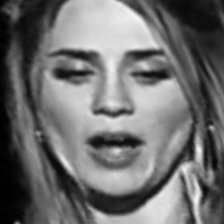

In [7]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[42][1])

In [8]:
def train_triplet(model, data_loader, num_epochs, lr=0.001):
  model.train()
  loss = torch.nn.TripletMarginLoss()
  loss_history = []
  print(f'lr: {lr}')
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(1, num_epochs+1):
    loss_accum = 0
    loss_cnt = 0
    for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
      ya = model(xa.to(device))
      yp = model(xp.to(device))
      yn = model(xn.to(device))
      loss_data = loss(ya, yp, yn)
      
      optimizer.zero_grad()
      loss_data.backward()
      optimizer.step()
      
      loss_accum += float(loss_data)
      loss_cnt += 1

    loss_value = loss_accum / loss_cnt
    print(f'loss: {loss_value}')

    if loss_history and loss_value > loss_history[-1]:
      lr *= 0.1
      print(f'lr: {lr}')
      optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history.append(loss_value)

  return loss_history

In [9]:
def create_faceid_model():
  model = torchvision.models.resnet50(weights='DEFAULT')
  model.fc = nn.Linear(model.fc.in_features, 16)
  return model

def grayscale_fix_model(model):
  w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
  model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model.conv1.weight.data = w
  return model

def set_trainable(model):
  model.requires_grad_(False)
  model.fc.requires_grad_(True)

def bind_model2device(model):
  model.to(device)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
bind_model2device(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [10]:
import psutil
psutil.cpu_count()

8

In [11]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=psutil.cpu_count())

In [12]:
loss_history = train_triplet(model, data_loader, 10)
plt.plot(loss_history)
plt.title('loss');

lr: 0.001


train 1/10:  42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 51/122 [01:24<01:57,  1.66s/it]


KeyboardInterrupt: 

In [ ]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [ ]:
model(dataset[42][0].reshape(1, 1, 224, 224).to(device))

In [ ]:
def cos_similarity(v1, v2):
  val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
  return val.reshape(-1)[0]

def euc_similarity(v1, v2):
  return np.linalg.norm(v1-v2)

In [ ]:
for i in range(10):
  v1 = model(dataset[42][0].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v2 = model(dataset[42][1].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v3 = model(dataset[42][2].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  print(euc_similarity(v1, v2), euc_similarity(v1, v3), cos_similarity(v1, v2), cos_similarity(v1, v3))

In [13]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=psutil.cpu_count())

In [14]:
model.requires_grad_(True)
loss_history = train_triplet(model, data_loader, 5, lr=0.00001)
plt.plot(loss_history)
plt.title('loss');

lr: 1e-05


train 1/5:   1%|██▏                                                                                                                                                                   | 13/976 [00:09<11:16,  1.42it/s]


KeyboardInterrupt: 

In [ ]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [ ]:
for i in range(10):
  v1 = model(dataset[42][0].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v2 = model(dataset[42][1].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v3 = model(dataset[42][2].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  print(euc_similarity(v1, v2), euc_similarity(v1, v3), cos_similarity(v1, v2), cos_similarity(v1, v3))

In [ ]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt